In [1]:
import db_helpers as dbh
import db_parse as dbp
import json
import pandas as pd
from pprint import pprint
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [2]:
data_dir = "data"
revision = "test"
do_wipe = False
do_import = False
do_describe = False

In [3]:
conn = dbh.Connection("dos")
if do_describe:
    print(f"Connected to database: {conn.db_name()}")
    conn.describe()
    conn.row_counts()
    conn.db_query("select distinct metric from data")

In [4]:
# revision_id = conn.nickname_id("revisions", revision)
# materialization_id = conn.nickname_id("materializations", materialization)
# session_id = dbh.result_as_value(conn.db_query("select id from sessions where nickname='{}'".format(session)))

In [5]:
df = pd.DataFrame(
    conn.db_query(
    """
    SELECT
        hostname,
        hostnum::int AS Client,
        (settings->>'attack_type') AS attack_type,
        (settings->>'mitigation') AS Mitigation,
        (settings->>'bottleneck_capacity')::int,
        (settings->>'bottleneck_latency')::int,
        (settings->>'bottleneck_loss')::float,
        (settings->>'client_interval')::float,
        (settings->>'mitigated_attack_type') AS mitigated_attack,
        (settings->>'syn_pow_verifier') AS Verifier,
        (settings->>'n_attackers')::int AS Attackers,
        (settings->>'client_app') AS client_app,
        (settings->>'file_size') AS file_size,
        (settings->>'attacker_busywait')::int AS busywait,
        (settings->>'attacker_cpu_limit')::int AS attacker_cpu_limit,
        metric,
        ub,
        mb,
        ua,
        ma,
        efficacy,
        overhead,
        threat,
        damage,
        efficacy_pct,
        efficacy_pct_threat,
        efficacy_relative,
        overhead_pct,
        threat_pct,
        damage_pct
    FROM results
    JOIN experiments ON results.experiment = experiments.id
    JOIN hosts ON results.host = hosts.id
    JOIN sessions ON experiments.session = sessions.id
    WHERE
        (sessions.nickname IN ('quic_loss'))
    """
    ), columns=["Hostname", "Client", "Attack", "Mitigation", "Bottleneck Capacity", "Bottleneck Latency", "Bottleneck Loss",
                "Client Delay", "Mitigated Attack", "Verifier", "Attackers", "Client Application", "File Size",
                "Attacker Busywait", "Attacker CPU Limit", "Metric", "UB", "MB", "UA", "MA",
                "Efficacy", "Overhead", "Threat", "Damage", "Efficacy Percent", "Efficacy Percent Threat",
                "Relative Efficacy", "Overhead Percent", "Threat Percent", "Damage Percent"]
)

ValueError: 29 columns passed, passed data had 30 columns

In [ ]:
mitigation_k_map = {
    'syn_pow_0': 0,
    'syn_pow_8': 8,
    'syn_pow_32': 32,
    'syn_pow_64': 64,
    'syn_pow_256': 256,
    'syn_pow_1024': 1024
}
df["Client/Server k"] = df["Mitigation"].map(mitigation_k_map)

mitigation_map = {
    'syn_pow_0': 'eBPF No-Op',
    'syn_pow_8': 'SYN PoW (k=8)',
    'syn_pow_32':'SYN PoW (k=32)',
    'syn_pow_64': 'SYN PoW (k=64)',
    'syn_pow_256': 'SYN PoW (k=256)',
    'syn_cookies': 'SYN Cookies',
    'syn_pow_8_cookies': 'SYN Cookies + PoW (k=8)',
    'syn_pow_64_cookies': 'SYN Cookies + PoW (k=64)',
    'syn_pad': 'SYN Padding',
    'syn_pad_cookies': 'SYN Cookies + Padding',
    'quic_retry': 'QUIC Retry'
}
df["DoS Mitigation"] = df["Mitigation"].map(mitigation_map)

mitigated_attack_k_map = {
    'syn_flood': 0,
    'syn_flood_pow_8': 8,
    'syn_flood_pow_32': 32,
    'syn_flood_pow_64': 64,
    'syn_flood_pow_256': 256,
    'syn_flood_pow_1024': 1024
}
df["Attacker k"] = df["Mitigated Attack"].map(mitigated_attack_k_map)

flood_type_map = {
    'syn_flood': 'Dumb',
    'syn_flood_pow_8': 'Smart',
    'syn_flood_pow_32': 'Smart',
    'syn_flood_pow_64': 'Smart',
    'syn_flood_pow_256': 'Smart',
    'syn_flood_pow_1024': 'Smart',
    'syn_flood_padded': 'Smart'
}

attack_map = {
    'syn_flood': 'TCP SYN',
    'quic_prebuilt': 'QUIC Initial'
}
df["Flood Type"] = df["Mitigated Attack"].map(attack_map)#(flood_type_map)



client_app_map = {
    'tcp': 'TCP Setup',
    'http': 'HTTP',
    'https': 'HTTPS',
    'http2': 'HTTPS 2',
    'http3': 'HTTP3/QUIC',
}
df["Application"] = df["Client Application"].map(client_app_map)

client_location_map = {
    0: 'A',
    1: 'A',
    2: 'A',
    3: 'B',
    4: 'B',
    5: 'B',
    6: 'C',
    7: 'C',
    8: 'C',
    9: 'D',
    10: 'D',
    11: 'D',
}
df["Client Subnet"] = df["Client"].map(client_location_map)
df["Client Location"] = df["Client Subnet"].map({
    'A': 'LAN',
    'B': 'Local',
    'C': 'Remote',
    'D': 'Sink'
})
# attacker_k_map = {
#     'syn_flood': 0,
#     'syn_flood_pow_8': 8,
#     'syn_flood_pow_32': 32
# }
# df["Attacker k"] = df["Mitigated Attack"].map(attacker_k_map)

verifier_map = {
    's0': 'Server',
    'firewall': 'Firewall',
    'edge_router': 'Edge Routers'
}
df["Verifier Location"] = df["Verifier"].map(verifier_map)

df["Attack Strength"] = df["Attackers"] * 0.01 * df["Attacker CPU Limit"]

# mitigation_map = {
#     'syn_pad': 'SYN Padding',
#     'syn_pow_8': 'SYN PoW (k=8)',
#     'syn_pow_64': 'SYN PoW (k=64)'
# }
# df["Mitigation Approach"] = df["Mitigation"].map(verifier_map)

In [ ]:
# Variables

for col in df:
    if col not in ['UB', 'UA', 'MB', 'MA', 'Threat', 'Damage', 'Efficacy', 'Overhead', 'Threat Percent', 'Damage Percent', 'Efficacy Percent', 'Efficacy Percent Threat', 'Relative Efficacy', 'Overhead Percent']:
        print("{}: {}".format(col, df[col].unique()))

Hostname: ['c10' 'c0' 'c5' 'c6' 'c8' 'c4' 'c9' 'c11' 'c3' 'c2' 'c7' 'c1']
Client: [10  0  5  6  8  4  9 11  3  2  7  1]
Attack: ['syn_flood' 'quic_prebuilt']
Mitigation: ['syn_cookies' 'quic_retry']
Bottleneck Capacity: [1000]
Bottleneck Latency: [1]
Client Delay: [0.]
Mitigated Attack: ['syn_flood' 'quic_prebuilt']
Verifier: ['s0']
Attackers: [4]
Client Application: ['https' 'http2' 'http3' 'http']
File Size: ['1K' '1M' '10M' '100M']
Attacker Busywait: [0]
Attacker CPU Limit: [100]
Metric: ['Transaction Duration' 'Transaction Status' 'Transactions per Second']
Client/Server k: [nan]
DoS Mitigation: ['SYN Cookies' 'QUIC Retry']
Attacker k: [ 0. nan]
Flood Type: ['TCP SYN' 'QUIC Initial']
Application: ['HTTPS' 'HTTPS 2' 'HTTP3/QUIC' 'HTTP']
Client Subnet: ['D' 'A' 'B' 'C']
Client Location: ['Sink' 'LAN' 'Local' 'Remote']
Verifier Location: ['Server']
Attack Strength: [4.]


In [ ]:
# Plot Settings

sns.set(style="whitegrid")
application_order = ["HTTP", "HTTPS", "HTTP3/QUIC"]
location_order = ['LAN', 'Local', 'Remote', 'Sink']
df_plt = df.loc[
    (df['Metric'] == 'Transactions per Second') &
    (df['Application']).isin(application_order)
]
dfp_1=df_plt.loc[
    (df_plt['File Size'] == '1K')
]
dfp_2=df_plt.loc[
    (df_plt['File Size'] == '1M')
]
dfp_3=df_plt.loc[
    (df_plt['File Size'] == '10M')
]
dfp_4=df_plt.loc[
    (df_plt['File Size'] == '100M')
]
dfp_1a=dfp_1.loc[
    (df_plt['DoS Mitigation'] == 'SYN Cookies')
]
dfp_1b=dfp_1.loc[
    (df_plt['DoS Mitigation'] == 'QUIC Retry')
]
dfp_2a=dfp_2.loc[
    (df_plt['DoS Mitigation'] == 'SYN Cookies')
]
dfp_2b=dfp_2.loc[
    (df_plt['DoS Mitigation'] == 'QUIC Retry')
]
dfp_3a=dfp_3.loc[
    (df_plt['DoS Mitigation'] == 'SYN Cookies')
]
dfp_3b=dfp_3.loc[
    (df_plt['DoS Mitigation'] == 'QUIC Retry')
]
dfp_4a=dfp_4.loc[
    (df_plt['DoS Mitigation'] == 'SYN Cookies')
]
dfp_4b=dfp_4.loc[
    (df_plt['DoS Mitigation'] == 'QUIC Retry')
]

Text(0.5, 0.98, 'Baseline Performance')

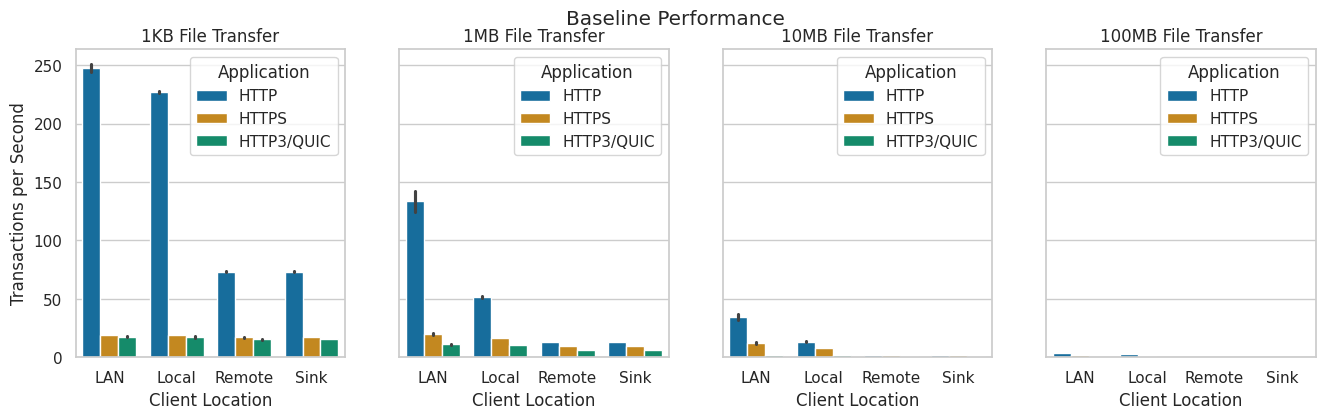

In [ ]:
# Baseline (TPS)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)

sns.barplot(
    ax=ax1,
    data=dfp_1,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order
)

sns.barplot(
    ax=ax2,
    data=dfp_2,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order
)

sns.barplot(
    ax=ax3,
    data=dfp_3,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order
)

sns.barplot(
    ax=ax4,
    data=dfp_4,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order
)
ax1.set_ylabel('Transactions per Second')
ax1.set_title('1KB File Transfer')
ax2.set_title('1MB File Transfer')
ax3.set_title('10MB File Transfer')
ax4.set_title('100MB File Transfer')
fig.suptitle('Baseline Performance')

Text(0.5, 0.98, 'Baseline Performance')

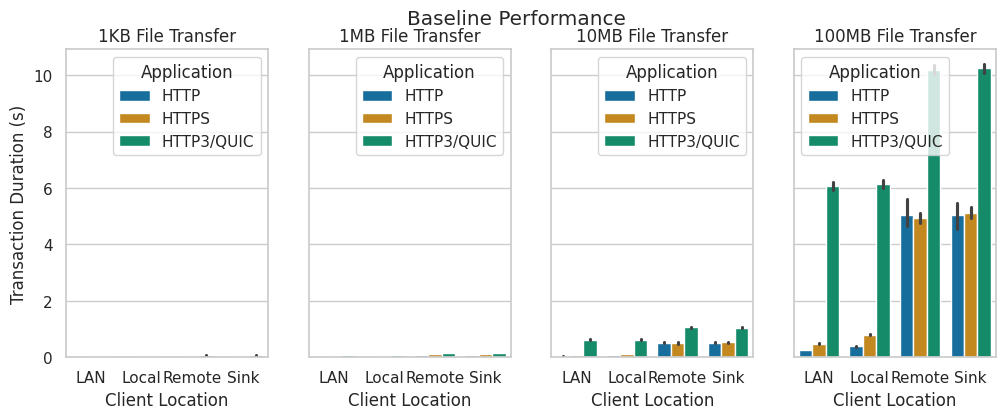

In [ ]:
# Baseline (s)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)

sns.barplot(
    ax=ax1,
    data=dfp_1,
    x='Client Location',
    order=['LAN', 'Local', 'Remote', 'Sink'],
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order
)

sns.barplot(
    ax=ax2,
    data=dfp_2,
    x='Client Location',
    order=['LAN', 'Local', 'Remote', 'Sink'],
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order
)

sns.barplot(
    ax=ax3,
    data=dfp_3,
    x='Client Location',
    order=['LAN', 'Local', 'Remote', 'Sink'],
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order
)

sns.barplot(
    ax=ax4,
    data=dfp_4,
    x='Client Location',
    order=['LAN', 'Local', 'Remote', 'Sink'],
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order
)

ax1.set_ylabel('Transaction Duration (s)')
ax1.set_title('1KB File Transfer')
ax2.set_title('1MB File Transfer')
ax3.set_title('10MB File Transfer')
ax4.set_title('100MB File Transfer')
fig.suptitle('Baseline Performance')

Text(106.99999999999999, 0.5, 'Overhead (TPS)')

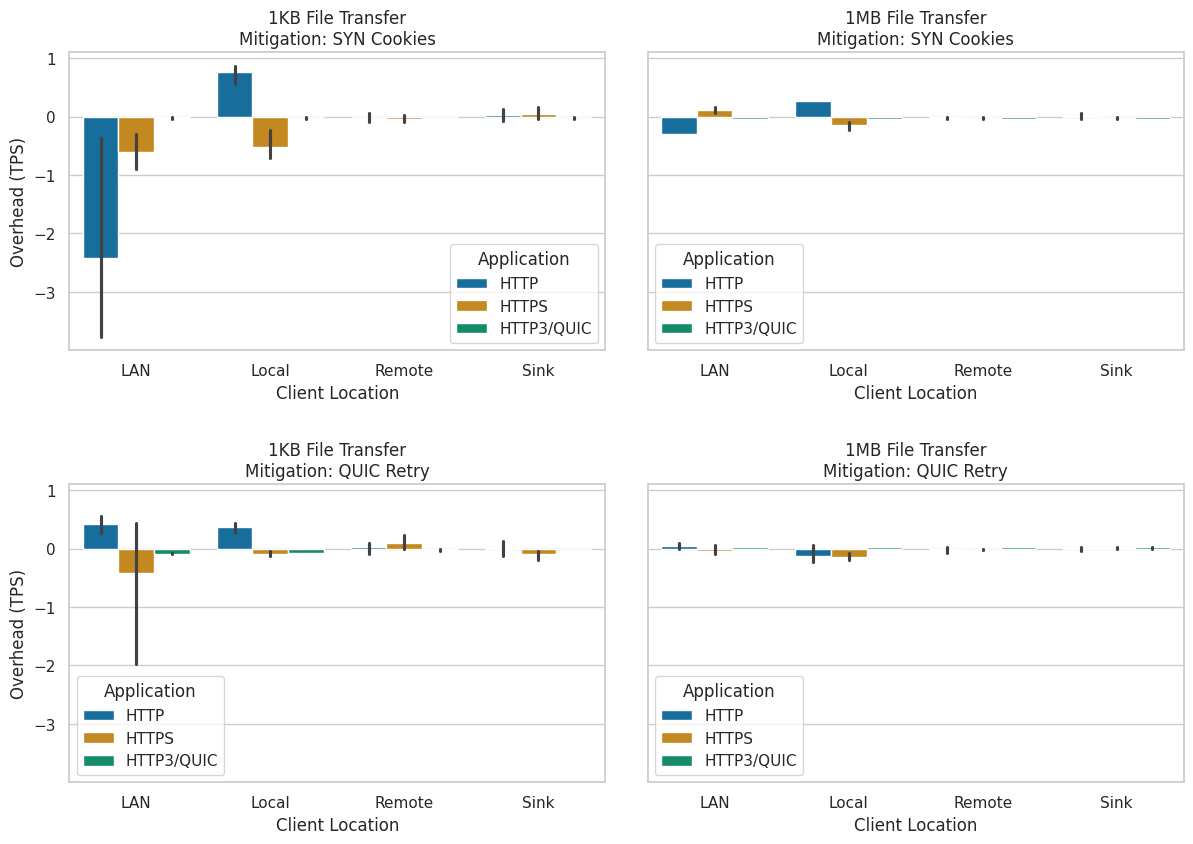

In [ ]:
# Overhead (TPS)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
fig.tight_layout(h_pad=6)

sns.barplot(
    ax=ax1,
    data=dfp_1a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Overhead',
    palette='colorblind',
    hue_order=application_order
)
ax1.set_title('1KB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax2,
    data=dfp_2a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Overhead',
    palette='colorblind',
    hue_order=application_order
)
ax2.set_title('1MB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax3,
    data=dfp_1b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Overhead',
    palette='colorblind',
    hue_order=application_order
)
ax3.set_title('1KB File Transfer\nMitigation: QUIC Retry')

sns.barplot(
    ax=ax4,
    data=dfp_2b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Overhead',
    palette='colorblind',
    hue_order=application_order
)
ax4.set_title('1MB File Transfer\nMitigation: QUIC Retry')
ax1.set_ylabel('Overhead (TPS)')
ax3.set_ylabel('Overhead (TPS)')


Text(106.99999999999999, 0.5, 'Overhead (% of Baseline)')

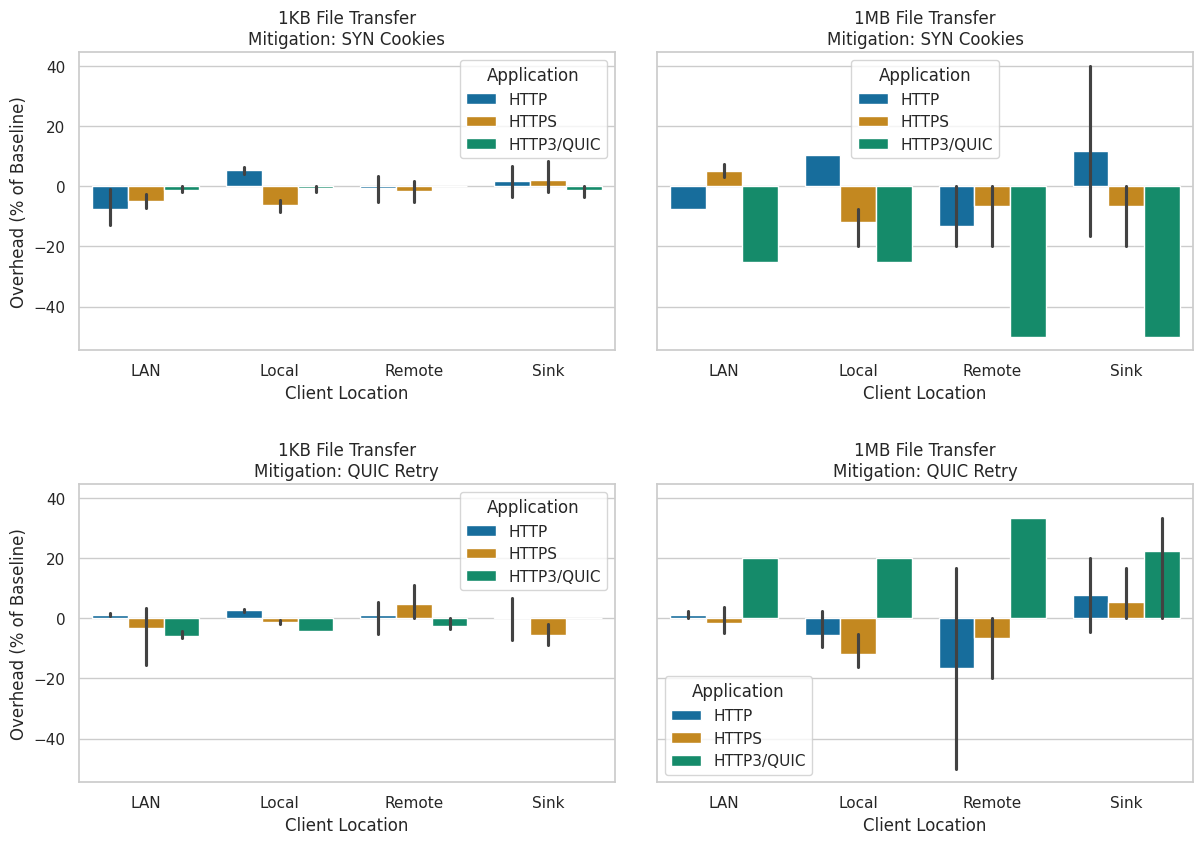

In [ ]:
# Overhead (%)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
fig.tight_layout(h_pad=6)

sns.barplot(
    ax=ax1,
    data=dfp_1a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Overhead Percent',
    palette='colorblind',
    hue_order=application_order
)
ax1.set_title('1KB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax2,
    data=dfp_2a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Overhead Percent',
    palette='colorblind',
    hue_order=application_order
)
ax2.set_title('1MB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax3,
    data=dfp_1b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Overhead Percent',
    palette='colorblind',
    hue_order=application_order
)
ax3.set_title('1KB File Transfer\nMitigation: QUIC Retry')

sns.barplot(
    ax=ax4,
    data=dfp_2b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Overhead Percent',
    palette='colorblind',
    hue_order=application_order
)
ax4.set_title('1MB File Transfer\nMitigation: QUIC Retry')
ax1.set_ylabel('Overhead (% of Baseline)')
ax3.set_ylabel('Overhead (% of Baseline)')


Text(106.99999999999999, 0.5, 'Threat (TPS)')

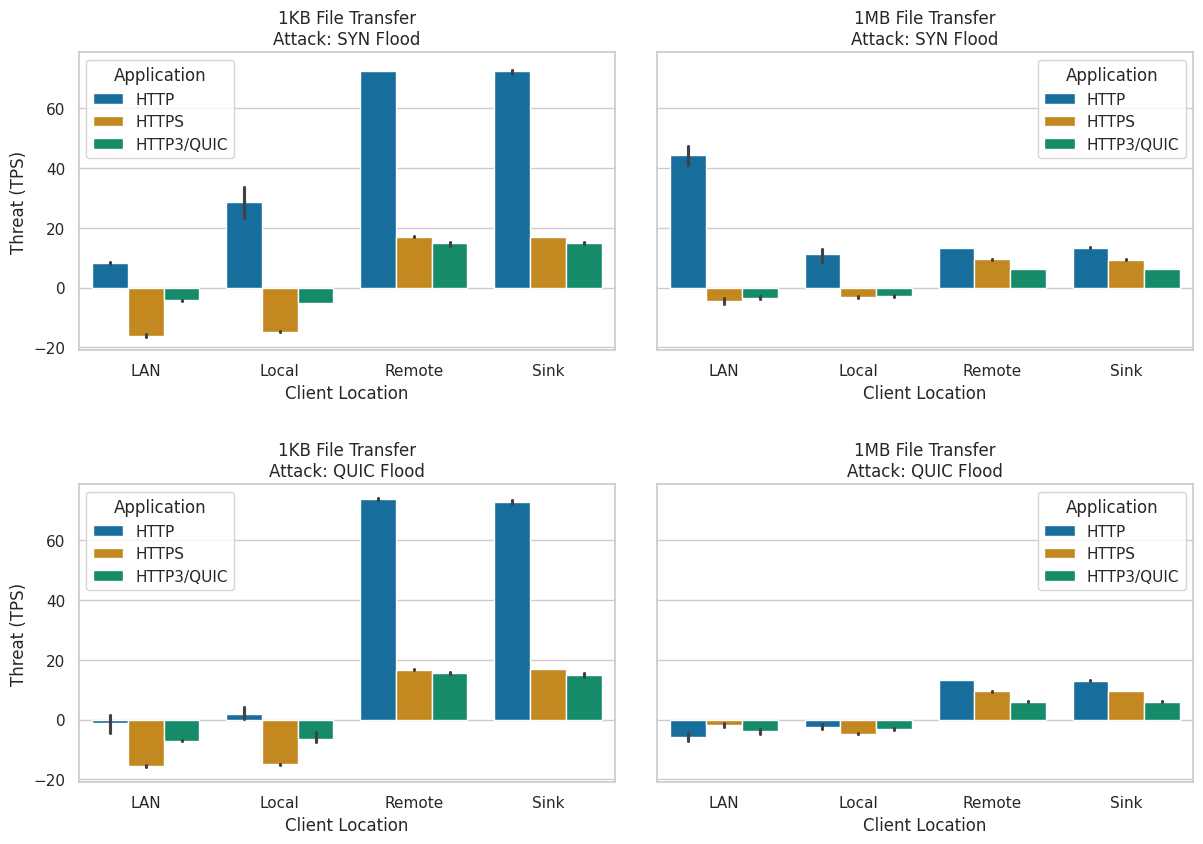

In [ ]:
# Threat (TPS)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
fig.tight_layout(h_pad=6)

sns.barplot(
    ax=ax1,
    data=dfp_1a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Threat',
    palette='colorblind',
    hue_order=application_order
)
ax1.set_title('1KB File Transfer\nAttack: SYN Flood')

sns.barplot(
    ax=ax2,
    data=dfp_2a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Threat',
    palette='colorblind',
    hue_order=application_order
)
ax2.set_title('1MB File Transfer\nAttack: SYN Flood')

sns.barplot(
    ax=ax3,
    data=dfp_1b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Threat',
    palette='colorblind',
    hue_order=application_order
)
ax3.set_title('1KB File Transfer\nAttack: QUIC Flood')

sns.barplot(
    ax=ax4,
    data=dfp_2b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Threat',
    palette='colorblind',
    hue_order=application_order
)
ax4.set_title('1MB File Transfer\nAttack: QUIC Flood')
ax1.set_ylabel('Threat (TPS)')
ax3.set_ylabel('Threat (TPS)')


Text(106.99999999999999, 0.5, 'Threat (% of Baseline)')

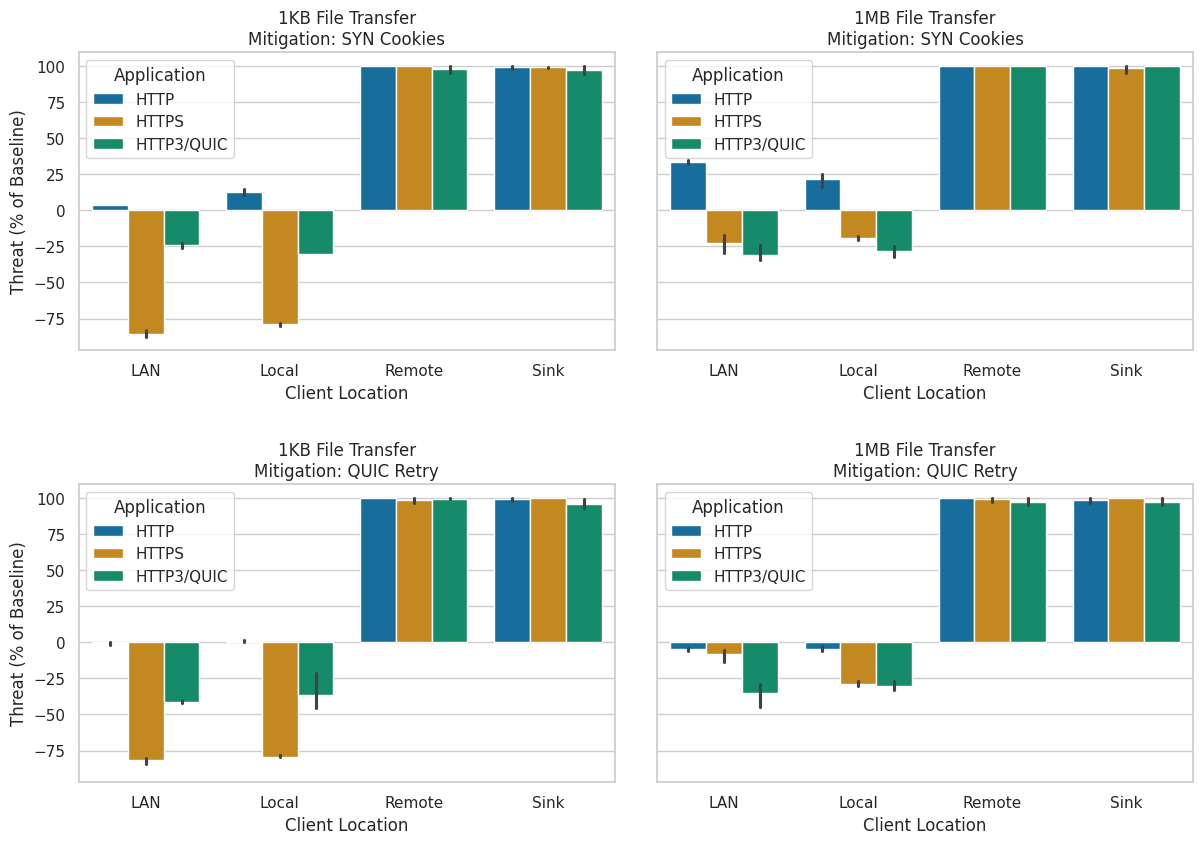

In [ ]:
# Threat (%)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
fig.tight_layout(h_pad=6)

sns.barplot(
    ax=ax1,
    data=dfp_1a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Threat Percent',
    palette='colorblind',
    hue_order=application_order
)
ax1.set_title('1KB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax2,
    data=dfp_2a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Threat Percent',
    palette='colorblind',
    hue_order=application_order
)
ax2.set_title('1MB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax3,
    data=dfp_1b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Threat Percent',
    palette='colorblind',
    hue_order=application_order
)
ax3.set_title('1KB File Transfer\nMitigation: QUIC Retry')

sns.barplot(
    ax=ax4,
    data=dfp_2b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Threat Percent',
    palette='colorblind',
    hue_order=application_order
)
ax4.set_title('1MB File Transfer\nMitigation: QUIC Retry')
ax1.set_ylabel('Threat (% of Baseline)')
ax3.set_ylabel('Threat (% of Baseline)')


Text(106.99999999999999, 0.5, 'Efficacy (TPS)')

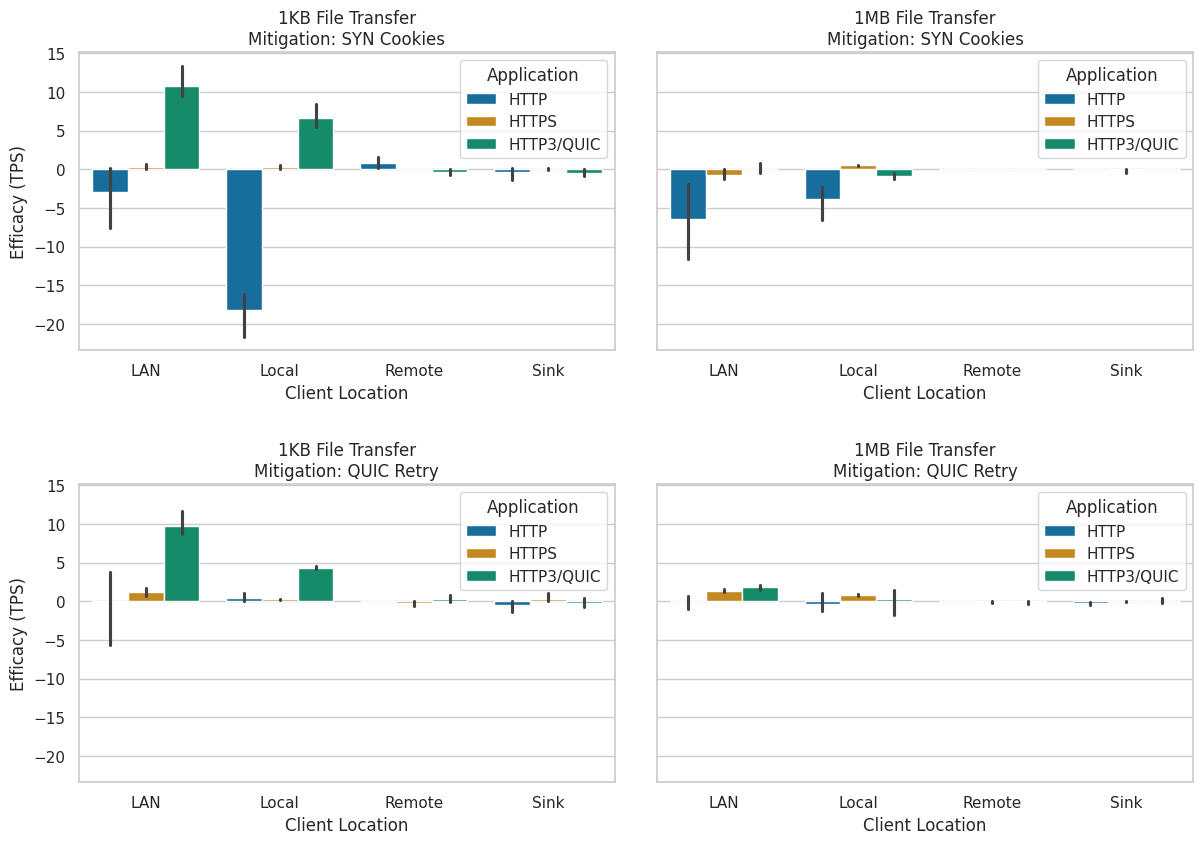

In [ ]:
# Efficacy (TPS)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
fig.tight_layout(h_pad=6)

sns.barplot(
    ax=ax1,
    data=dfp_1a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy',
    palette='colorblind',
    hue_order=application_order
)
ax1.set_title('1KB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax2,
    data=dfp_2a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy',
    palette='colorblind',
    hue_order=application_order
)
ax2.set_title('1MB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax3,
    data=dfp_1b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy',
    palette='colorblind',
    hue_order=application_order
)
ax3.set_title('1KB File Transfer\nMitigation: QUIC Retry')

sns.barplot(
    ax=ax4,
    data=dfp_2b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy',
    palette='colorblind',
    hue_order=application_order
)
ax4.set_title('1MB File Transfer\nMitigation: QUIC Retry')
ax1.set_ylabel('Efficacy (TPS)')
ax3.set_ylabel('Efficacy (TPS)')

Text(106.99999999999999, 0.5, 'Efficacy (% of Baseline)')

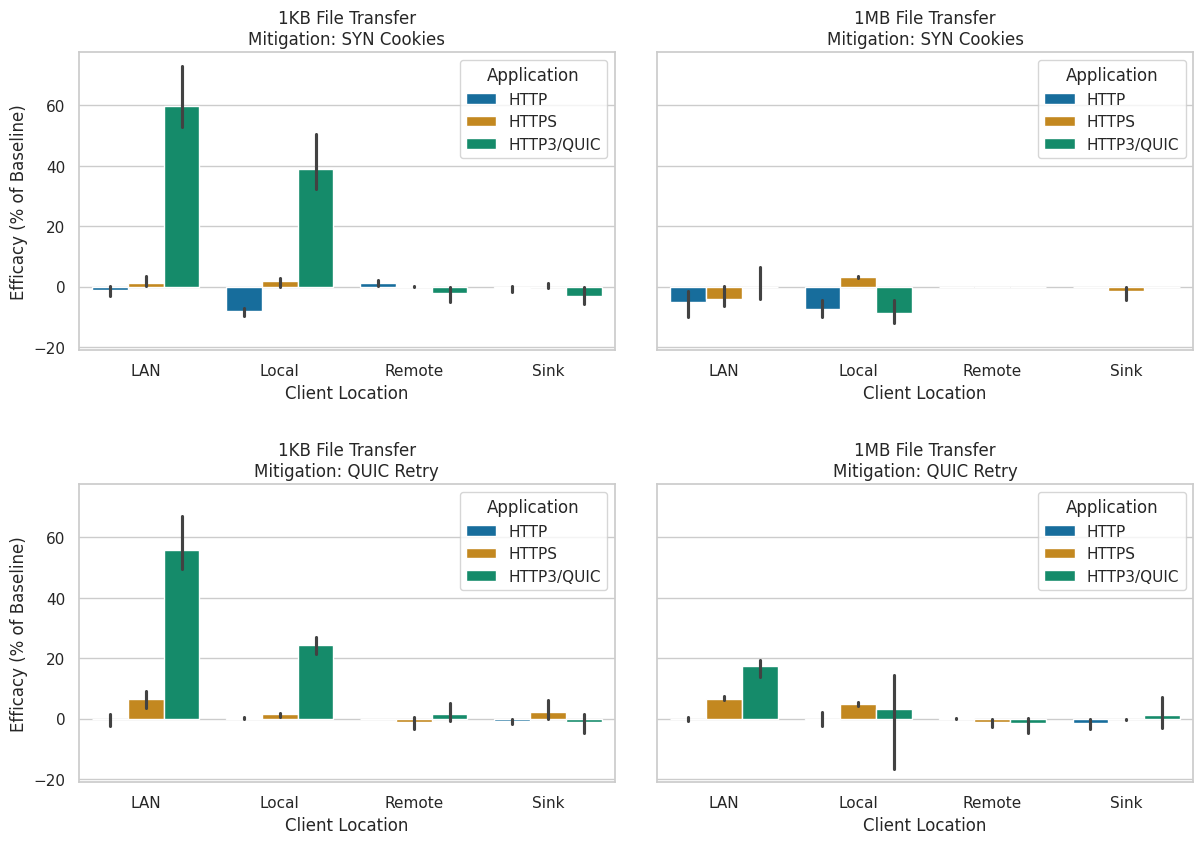

In [ ]:
# Efficacy (% Baseline)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
fig.tight_layout(h_pad=6)

sns.barplot(
    ax=ax1,
    data=dfp_1a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy Percent',
    palette='colorblind',
    hue_order=application_order
)
ax1.set_title('1KB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax2,
    data=dfp_2a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy Percent',
    palette='colorblind',
    hue_order=application_order
)
ax2.set_title('1MB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax3,
    data=dfp_1b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy Percent',
    palette='colorblind',
    hue_order=application_order
)
ax3.set_title('1KB File Transfer\nMitigation: QUIC Retry')

sns.barplot(
    ax=ax4,
    data=dfp_2b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy Percent',
    palette='colorblind',
    hue_order=application_order
)
ax4.set_title('1MB File Transfer\nMitigation: QUIC Retry')
ax1.set_ylabel('Efficacy (% of Baseline)')
ax3.set_ylabel('Efficacy (% of Baseline)')

Text(106.99999999999999, 0.5, 'Efficacy (% of Threat)')

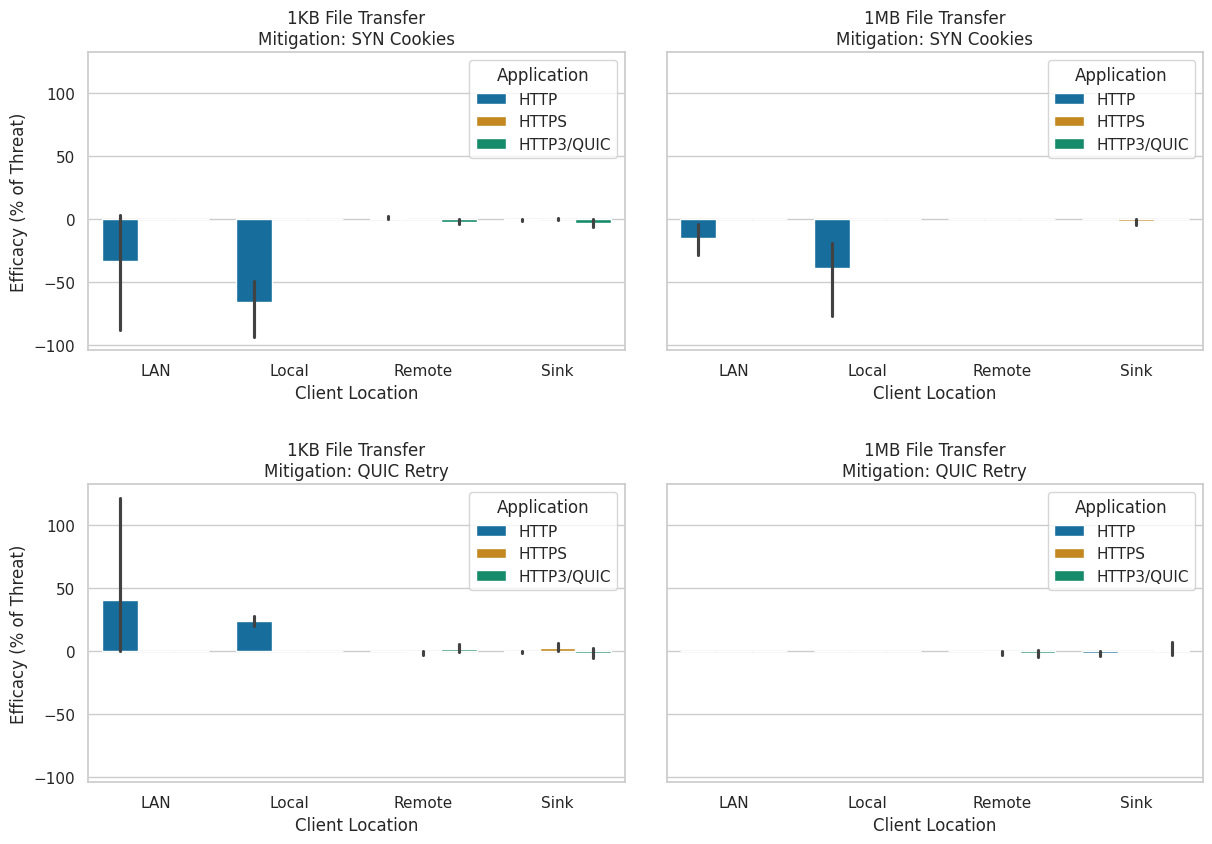

In [ ]:
# Efficacy (% Threat)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
fig.tight_layout(h_pad=6)

sns.barplot(
    ax=ax1,
    data=dfp_1a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy Percent Threat',
    palette='colorblind',
    hue_order=application_order
)
ax1.set_title('1KB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax2,
    data=dfp_2a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy Percent Threat',
    palette='colorblind',
    hue_order=application_order
)
ax2.set_title('1MB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax3,
    data=dfp_1b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy Percent Threat',
    palette='colorblind',
    hue_order=application_order
)
ax3.set_title('1KB File Transfer\nMitigation: QUIC Retry')

sns.barplot(
    ax=ax4,
    data=dfp_2b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy Percent Threat',
    palette='colorblind',
    hue_order=application_order
)
ax4.set_title('1MB File Transfer\nMitigation: QUIC Retry')
ax1.set_ylabel('Efficacy (% of Threat)')
ax3.set_ylabel('Efficacy (% of Threat)')

Text(0.5, 1.0, '1MB File Transfer\nMitigation: QUIC Retry')

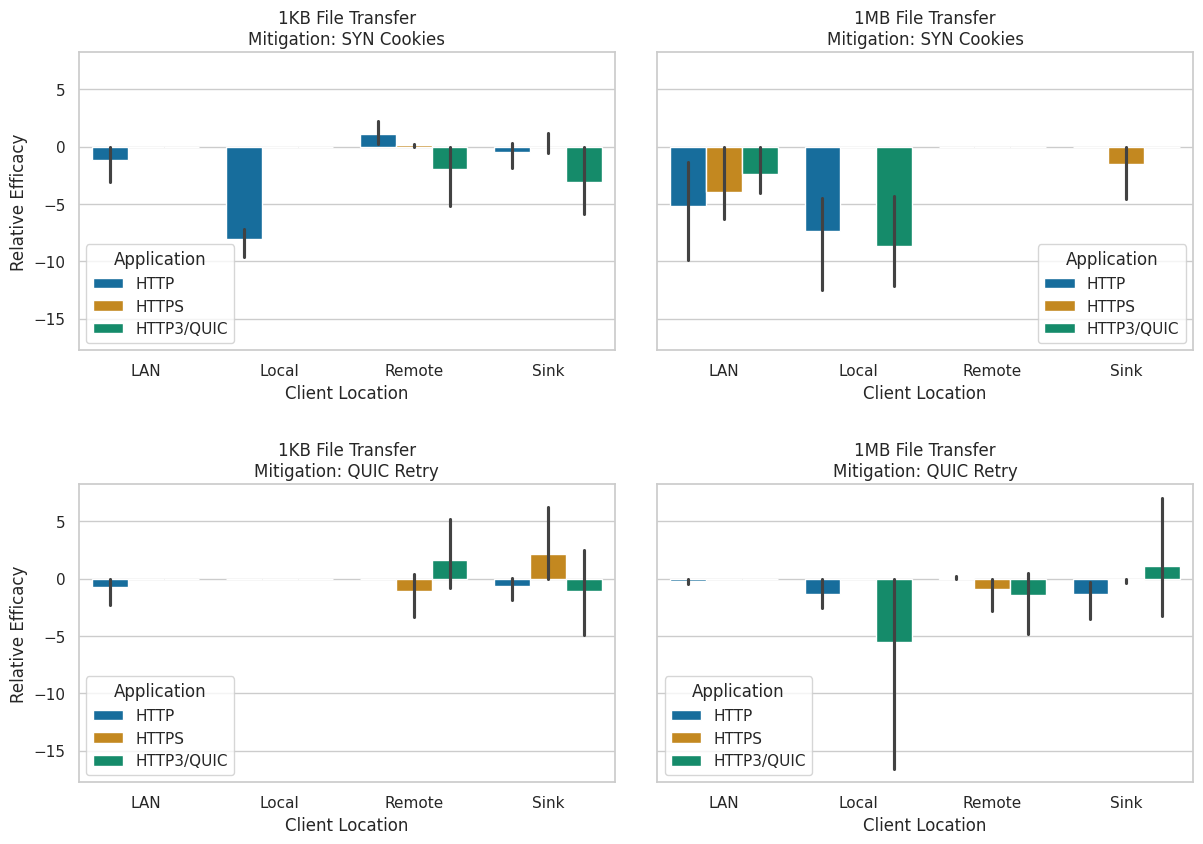

In [ ]:
# Relative Efficacy

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
fig.tight_layout(h_pad=6)

sns.barplot(
    ax=ax1,
    data=dfp_1a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Relative Efficacy',
    palette='colorblind',
    hue_order=application_order
)
ax1.set_title('1KB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax2,
    data=dfp_2a,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Relative Efficacy',
    palette='colorblind',
    hue_order=application_order
)
ax2.set_title('1MB File Transfer\nMitigation: SYN Cookies')

sns.barplot(
    ax=ax3,
    data=dfp_1b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Relative Efficacy',
    palette='colorblind',
    hue_order=application_order
)
ax3.set_title('1KB File Transfer\nMitigation: QUIC Retry')

sns.barplot(
    ax=ax4,
    data=dfp_2b,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Relative Efficacy',
    palette='colorblind',
    hue_order=application_order
)
ax4.set_title('1MB File Transfer\nMitigation: QUIC Retry')